Saving images (1).jpg to images (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


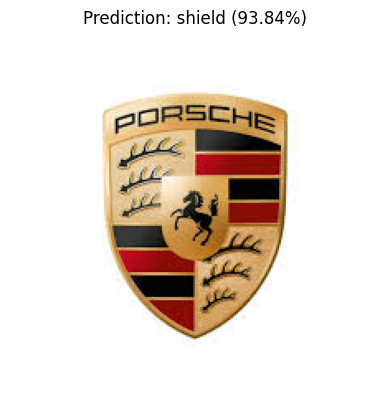

Top Predictions:
1. shield: 93.84%
2. pick: 3.54%
3. buckle: 0.32%


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
model = ResNet50(weights='imagenet')
preds = model.predict(x)
decoded_preds = decode_predictions(preds, top=3)[0]
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {decoded_preds[0][1]} ({decoded_preds[0][2]*100:.2f}%)")
plt.show()

print("Top Predictions:")
for i, (imagenetID, label, score) in enumerate(decoded_preds):
    print(f"{i+1}. {label}: {score*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_354']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


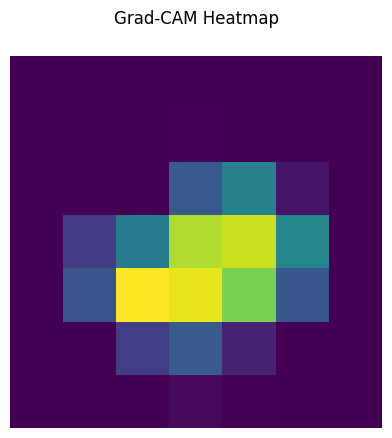

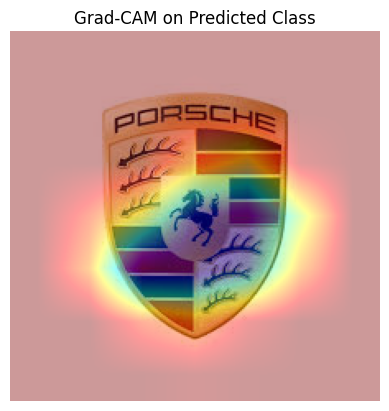

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_output = last_conv_output[0]
    heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

last_conv_layer_name = "conv5_block3_out"
heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM on Predicted Class")
plt.show()

In [ ]:
import google.generativeai as genai
from PIL import Image
import cv2

genai.configure(api_key="!===YOUR GEMINI API KEY HERE===!")
cv2.imwrite("gradcam_output.jpg", cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
cam_image = Image.open("gradcam_output.jpg")

prompt = f"""
You are an AI explainability assistant.
The uploaded image shows a Grad-CAM visualization for a CNN model that classified it as a {decoded_preds[0][1]}.
Explain in natural, simple English what regions of the image were most influential in the model’s prediction,
and why those features might indicate that this image belongs to that class.
"""

model_gemini = genai.GenerativeModel("models/gemini-2.5-flash-preview-09-2025")
response = model_gemini.generate_content([prompt, cam_image])
print("Explanation from GEMINI:\n")
print(response.text)

Explanation from GEMINI:

This Grad-CAM visualization helps us understand exactly why the model classified this image as a "shield."

Here is the explanation of the model's focus:

### 1. Influential Regions (Where the Model Looked)

The most influential regions are indicated by the bright red and yellow areas on the heat map. The model did not focus on small details, but rather on the overall structure and geometry of the object:

*   **The Outline:** The model heavily focused on the defining **perimeter** of the emblem, particularly the curved sides and the pointed bottom that give it its specific shape.
*   **The Center:** The central area containing the smaller horse figure is also very bright. This indicates that the model used the central structure and the main dividing lines of the crest to confirm the shape.
*   **Focus on Structure:** The heat map shows that the model relied more on the **shape and structure** of the object rather than the specific text ("PORSCHE") or the back